In [1]:
from importlib import reload
from load_cluster_data import load_cluster_data
import gc

import numpy as np
import torch
import pandas as pd 
import seaborn as sns
import collections

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

float_type = { 
    "device" : device, 
    "dtype" : torch.float, # save memory
}

hypers = {
    "eta" : 1., 
    "alpha_prior" : 1., # karin had 0.65 
    "pi_prior" : 1.
}

K = 10

import plotnine as p9
import scipy.sparse as sp
import matplotlib.pyplot as plt 
import splicing_PCA_utils
from splicing_PCA_utils import make_Y
from nuclear_norm_PCA import sparse_sum

from pca_kmeans_init import pca_kmeans_init
from betabinomo_LDA_singlecells_kinit import *
import betabinomo_LDA_singlecells_kinit
reload(betabinomo_LDA_singlecells_kinit)

import plotnine as p9
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_violin, theme
import plotnine


cpu


/gpfs/commons/home/kisaev/.local/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


### Load data

In [2]:
input_file = '/gpfs/commons/scratch/kisaev/ss_tabulamuris_test/Leaflet/brain_mouse_cells_noanno.h5'

In [3]:
final_data, coo_counts_sparse, coo_cluster_sparse, cell_ids_conversion, junction_ids_conversion = load_cluster_data(
    input_file)#, celltypes = ["Brain_Non-Myeloid_astrocyte_pseudobulk", "Brain_Non-Myeloid_endothelial_cell_pseudobulk"])

['Brain_Myeloid_macrophage_pseudobulk'
 'Brain_Non-Myeloid_Bergmann_glial_cell_pseudobulk'
 'Brain_Non-Myeloid_astrocyte_pseudobulk'
 'Brain_Non-Myeloid_brain_pericyte_pseudobulk'
 'Brain_Non-Myeloid_endothelial_cell_pseudobulk'
 'Brain_Non-Myeloid_neuron_pseudobulk'
 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell_pseudobulk'
 'Brain_Non-Myeloid_oligodendrocyte_pseudobulk']
3462
3462
63257
63257
The number of junctions in the data is:  63257
The number of cells in the data is:  3462
The number of cell types in the data is:  8


In [4]:
# still do preprocessing in scipy
indices = (final_data.cell_id_index, final_data.junction_id_index)
indices_np = np.stack(indices)

In [5]:
junc_counts = sp.coo_matrix((final_data.junc_count, indices))
cluster_counts = sp.coo_matrix((final_data.cluster_count, indices))

In [6]:
# set up data for nuc norm PCA
Y_data, w = splicing_PCA_utils.make_Y(
    junc_counts, cluster_counts, float_type)

In [7]:
# turn Y_data into COO matrix 
Y_data_coo = sp.coo_matrix((Y_data, indices))
Y_data_coo

<3462x63257 sparse matrix of type '<class 'numpy.float64'>'
	with 41473416 stored elements in COOrdinate format>

In [8]:
# run PCA on Y_data_coo where 3462 cells and 63257 junctions 
# reduce dimensionality of junctions with PCA while keeping the cells 
# (i.e. we want to keep the cell clusters, but reduce the number of junctions)
from sklearn.decomposition import PCA
from scipy.sparse import coo_matrix

# Assuming your sparse matrix is called 'sparse_matrix'
dense_matrix = Y_data_coo.toarray()

# Apply PCA
pca = PCA(n_components=2)  # Set the desired number of components
pca_result = pca.fit_transform(dense_matrix)

# Access the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

### Run PCA on these mean 0 centers junction usage ratios

In [11]:
cell_types = cell_ids_conversion.cell_type
pca = PCA(n_components=20)  # Set the number of components to 2 for visualization
pca_result = pca.fit_transform(dense_matrix)

In [12]:
def plot_pcas(pca_result, cell_types, pc1, pc2):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=pca_result[:, pc1], y=pca_result[:, pc2], hue=cell_types, size=0.25)
    plt.legend(fontsize='6', loc='upper left')
    plt.xlabel('Principal Component:' + str(pc1))
    plt.ylabel('Principal Component:' + str(pc2))
    plt.title('PCA Scatter Plot')
    plt.show()

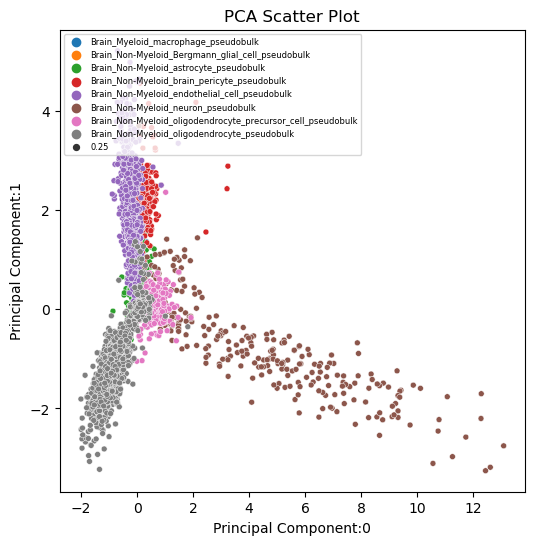

In [13]:
plot_pcas(pca_result, cell_types, 0, 1)

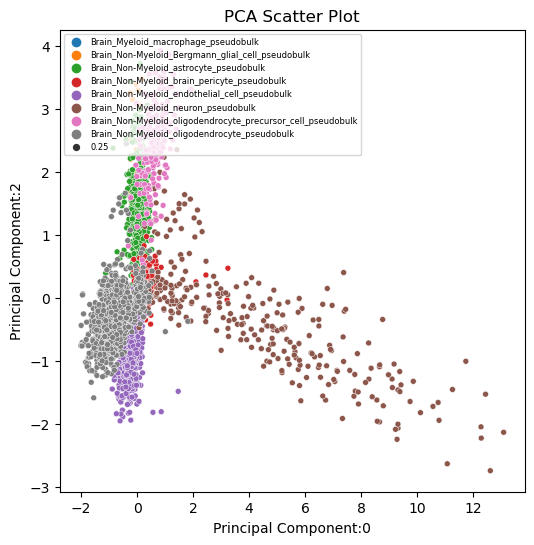

In [14]:
plot_pcas(pca_result, cell_types, 0, 2)

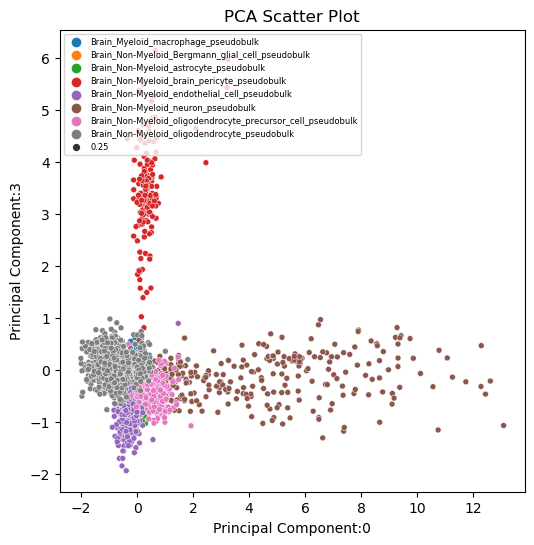

In [15]:
plot_pcas(pca_result, cell_types, 0, 3)

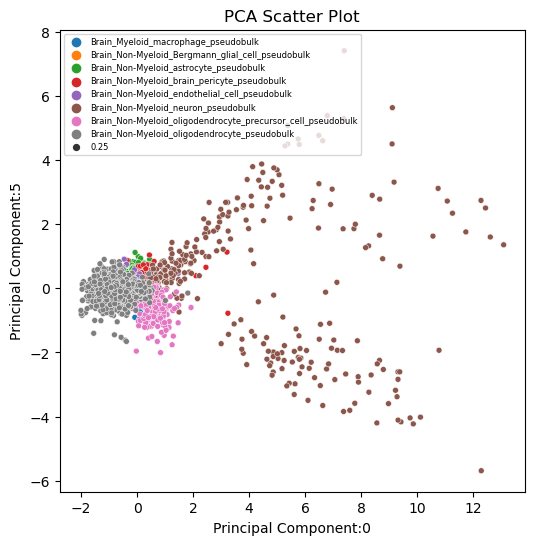

In [16]:
plot_pcas(pca_result, cell_types, 0, 5)

### Run LDA

In [ ]:
LDA_input=make_torch_data(final_data, **float_type)

In [ ]:
# make matrix of cell_ids as rows and junction_id_index as columns filled in by juncratio 
# this is the matrix we will use for PCA

# final_data_pivot = final_data.pivot(index='cell_id_index', columns='junction_id_index', values='juncratio').fillna(0) <- if junction usage ratios are all positive, then how do we know we are not just picking up expression?
# the zeroes im inputting here might just be cases where genes are just not expressed 

In [ ]:
print(final_data.head())
print(len(final_data.cell_id_index.unique())) # number of cells
print(len(final_data.junction_id_index.unique())) # number of junctions --> 125,611???? fixed now i think?

In [ ]:
#junction_data = final_data_pivot.iloc[:, 1:].values

# Standardize the data (mean=0, variance=1)
#scaler = StandardScaler()
#normalized_data = scaler.fit_transform(junction_data)
# Perform PCA

#pca = PCA(n_components=10)  # Set the number of components to 2 for visualization
#pca_result = pca.fit_transform(junction_data)

# make a few plots side by side comparing different PC combinations
# PC1 vs PC2

In [ ]:
num_trials = 1 # can't currently run more than 1 or overflow GPU memory :( 
num_iters = 20 # should also be an argument that gets fed in
K = 30

# run coordinate ascent VI
print("Number of topics to be learned is: ", K)
ALPHA_f, PI_f, GAMMA_f, PHI_f, elbos_all = calculate_CAVI(K, LDA_input, float_type, hypers = hypers, num_iterations = num_iters)
elbos_all = np.array(elbos_all)
# plot ELBO
plt.plot(elbos_all[2:]); plt.show()

In [ ]:
juncs_probs = ALPHA_f / (ALPHA_f+PI_f)

# how variable are juncs_probs across cell states/topics? 
plt.hist(juncs_probs.std(axis=1)); plt.show()

In [ ]:
juncs_probs_df = pd.DataFrame(juncs_probs, columns = range(K))
juncs_probs_df["junction_id_index"] = junction_ids_conversion.junction_id_index.values
# convert to juncs_probs to pandas dataframe and calculate mean and std across cell states/topics
juncs_probs_df["junction_id"] = junction_ids_conversion.junction_id.values

In [ ]:
def plot_juncObsUsage(junc_index):

    # print junction ID using junction_ids_conversion
    print(junction_ids_conversion[junction_ids_conversion["junction_id_index"] == junc_index])
    junc_id = junction_ids_conversion[junction_ids_conversion["junction_id_index"] == junc_index].junction_id.values[0]

    # get data for just junc_index 
    junc_dat=final_data[final_data.junction_id_index==junc_index]

    # make violin plot for junc_dat junction usage ratio coloured by cell_type and rotate plot 90 degrees
    plot = ggplot(junc_dat, aes(x='cell_type', y='juncratio', fill="cell_type")) + geom_violin() + geom_point() + plotnine.labels.ggtitle(junc_id) + plotnine.coords.coord_flip() 
    print(plot)

def plot_juncProbs(junc_index):
    
    # print junction ID using junction_ids_conversion
    print(junction_ids_conversion[junction_ids_conversion["junction_id_index"] == junc_index])
    junc_id = junction_ids_conversion[junction_ids_conversion["junction_id_index"] == junc_index].junction_id.values[0]
    
    # get data for just junc_index 
    junc_dat=juncs_probs_df[juncs_probs_df.junction_id_index==junc_index]
    junc_dat = junc_dat.melt().iloc[0:K]
    junc_dat.value = junc_dat.value.astype(float)
    # make violin plot for junc_dat junction usage ratio coloured by cell_type
    plot = ggplot(junc_dat, aes(x='variable', y='value')) + geom_point() 
    print(plot)


In [ ]:
juncs_probs_df.iloc[0]

In [ ]:
# indicate plot should be small 4 by 4
plotnine.options.figure_size = (4, 4)
plot_juncObsUsage(0)

In [ ]:
plot_juncProbs(0)

In [ ]:
theta_f = GAMMA_f / GAMMA_f.sum(1,keepdim=True)
theta_f_plot = pd.DataFrame(theta_f.cpu())
theta_f_plot['cell_id'] = cell_ids_conversion["cell_type"].to_numpy() # are these correct attachments? 
theta_f_plot.head()

In [ ]:
sns.violinplot(data=theta_f_plot, y="cell_id", x=9)

In [ ]:
sns.violinplot(data=theta_f_plot, y="cell_id", x=0)

In [ ]:
# use theta_f values to do PCA 
theta_f.shape

In [ ]:
# feed theta_f into PCA
pca = PCA(n_components=10)  # Set the number of components to 2 for visualization
pca_result = pca.fit_transform(theta_f)

In [ ]:
plot_pcas(pca_result, cell_types, 0, 1)

In [ ]:
plot_pcas(pca_result, cell_types, 0, 2)

In [ ]:
plot_pcas(pca_result, cell_types, 0, 3)

In [ ]:
plot_pcas(pca_result, cell_types, 0, 4)

In [ ]:
plot_pcas(pca_result, cell_types, 0, 5)

In [ ]:
pca_result

In [ ]:
# make heatmap using pca_result
sns.heatmap(pca_result)

In [ ]:
theta_f.shape

In [ ]:
color_mapping = {}
unique_cell_types = set(cell_types)
num_colors = len(unique_cell_types)
color_palette = sns.color_palette('hsv', num_colors)  # Choose a color palette
color_palette

In [ ]:
for i, cell_type in enumerate(unique_cell_types):
    color_mapping[cell_type] = color_palette[i]

In [ ]:
theta_f.shape

In [ ]:
sns.heatmap(theta_f)